![alt text](https://www.signavio.com/wp-content/uploads/2013/03/Logo-Universitaet-Osnabrueck-300x99.png)


**PROJECT REPORT**

*Implementing ANNs with Tensorflow  (8.3304)*


**Double DQN (Hasselt et al. 2015)**

Tensorflow Implementation for Solving OpenAI Gym Environments

### Imports and Setup

**Note**

This section contains all imports and objects necessary to run the main parts of each experiment below. Please only consult this section if you need additional information on the implementation specifics.

Import git repository into current session using below command to download code and trained model
`!git clone https://github.com/dpkpathak/ANNTFPROJ.git`

In [1]:
!git clone https://github.com/dpkpathak/ANNTFPROJ.git

Cloning into 'ANNTFPROJ'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 13 (delta 0), reused 10 (delta 0), pack-reused 0
Unpacking objects: 100% (13/13), done.


Change current working directory to the git repository.

In [ ]:
!cd ANNTFPROJ/

In [ ]:
# Tensorflow.
%tensorflow_version 2.x
import tensorflow as tf

# OpenAI Gym.
from gym import wrappers
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only

# Visualization.
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

# Other.
import os
import numpy as np
import math
import glob
import io
import random
from tqdm import tqdm
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import logging
tf.get_logger().setLevel(logging.ERROR)

In [ ]:
# Authenticate and create the PyDrive client for later visualization.
!pip install gym pyvirtualdisplay > /dev/null 2>&1   # for producing virtual display for environment to render
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Metavariables for DQN and DDQN experiments.

# Epsilon greedy policy variables.
max_epsilon = 1
min_epsilon = 0.01
lambda_ = 0.0005

# DQN algorithm variables.
gamma = 0.95
batch_size = 32
tau = 0.08
max_experiences = 500000
min_experiences = 96

# Network model variables.
hidden_units = [50,50]
steps = 0

# Environment variables.
env = gym.make("CartPole-v0")
num_actions = env.action_space.n
num_states = len(env.observation_space.sample())
num_episodes = 100
total_rewards = np.empty(num_episodes)
total_loss = np.empty(num_episodes)

In [ ]:
# Functions for testing trained agents and visualizing test performance.

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env
  

def make_video(env, agent):
    """
    Captures video of agent performance for a single episode.
    """
    env = wrap_env(env)
    rewards = 0
    steps = 0
    done = False
    state = env.reset()
    while not done:
        env.render()
        action = agent.get_action(state,0)
        state, reward, done, info= env.step(action)
        steps += 1
        rewards += reward
    print("Testing steps: {} rewards {}: ".format(steps, rewards))


def show_video():
  """
  Displays video of agent test.
  """
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

In [ ]:
# Class objects and functions for implementing the DQN and DDQN algorithms.

class Qnetwork(tf.keras.Model):
  """
  A single Q-value approximation network. Used for implementing online and target networks in DQN/DDQN.
  """
  def __init__(self, num_states, hidden_units, num_actions):
      super(Qnetwork, self).__init__()
      self.input_layer = tf.keras.layers.InputLayer(input_shape=(num_states,))
      self.hidden_layers = []
      for units in hidden_units:
          self.hidden_layers.append(tf.keras.layers.Dense(
              units, activation='relu', kernel_initializer=tf.keras.initializers.he_normal()))
      self.output_layer = tf.keras.layers.Dense(num_actions)

  @tf.function
  def call(self, inputs):
      x = self.input_layer(inputs)
      for layer in self.hidden_layers:
          x = layer(x)
      output = self.output_layer(x)
      return output


class ExperienceBuffer:
  """
  Stores experiences for training approximation network.
  """
  def __init__(self, max_experiences, min_experiences):
    self.max_experiences = max_experiences
    self.min_experiences = min_experiences
    self.experiences= []

  def add_experiences(self, exp):
    self.experiences.append(exp)
    if len(self.experiences) > self.max_experiences:
      self.experiences.pop(0)

In [ ]:
# Reinforcement learning agent class.

class Agent:
  """
  Reinforcement learning agent to implement DQN and DDQN algorithms.
  """
  def __init__(self, train_net, gamma, batch_size, num_actions, algorithm, experience, target_net=None):
    # Network for approximation function.
    self.train_net = train_net
    # Target network to regulate training.
    self.target_net = target_net
    # Discount factor for next states.
    self.gamma = gamma
    # Batch size for training network.
    self.batch_size = batch_size
    # Network optimizer.
    self.optimizer = tf.optimizers.Adam()
    # Loss function.
    self.mse = tf.keras.losses.MeanSquaredError()
    # Actions space.
    self.num_actions = num_actions
    # Algorithm: DQN or DDQN
    self.algorithm = algorithm
    # Experience buffer
    self.experience_buffer = experience


  def get_action(self, state, eps):
    """
    Select action based on epsilon-greedy policy values. As value decays, 
    the agent will tend to exploit the environment. Before decay, the agent 
    will explore the environment to gather experiences.
    """
    if random.random() < eps:
      # Explore.
      return random.randint(0, num_actions - 1)
    else:
      # Exploit.
      return np.argmax(self.train_net(state.reshape(1, -1)))


  def train(self,exp_buffer):
    """
    Update approximation function (network) based on prior experience and 
    either DQN or DDQN update algorithm.
    """
    # Return zero loss if not enough experiences for training.
    if len(exp_buffer.experiences) < exp_buffer.min_experiences:
        return 0
   
    # Gather experiences for training.
    ids = np.random.randint(low=0, high=len(exp_buffer.experiences), size=self.batch_size)
    states = np.array([exp_buffer.experiences[id_][0] for id_ in ids])
    actions = np.array([exp_buffer.experiences[id_][1] for id_ in ids])
    rewards = np.array([exp_buffer.experiences[id_][2] for id_ in ids])
    next_states = np.array([(np.zeros(4)if exp_buffer.experiences[id_][3] is None else exp_buffer.experiences[id_][3]) for id_ in ids])

    # Obtaining Q from states
    Q_train = self.train_net(states)
    # Obtaining Q prime from next states 
    Q_train_prime = self.train_net(next_states)
    # Compute target Q.
    Q_train_target = Q_train.numpy()

    updates = rewards

    # Select only valid ids for training, ie those without next state == 0.
    valid_idxs = np.array(next_states).sum(axis=1) != 0
    batch_idxs = np.arange(self.batch_size)

    if self.algorithm == 'dqn':    
      updates[valid_idxs] += self.gamma * np.amax(Q_train_prime.numpy()[valid_idxs, :], axis=1)

    elif self.algorithm == 'ddqn':
      A_prime = np.argmax(Q_train_prime.numpy(), axis=1)
      Q_target = self.target_net(next_states)
      updates[valid_idxs] += self.gamma * Q_target.numpy()[batch_idxs[valid_idxs], A_prime[valid_idxs]]

    Q_train_target[batch_idxs, actions] = updates
    with tf.GradientTape() as tape:
      output = self.train_net(states)
      loss = self.mse(Q_train_target, output)
      gradients = tape.gradient(loss, self.train_net.trainable_variables)

    # Apply gradients
    self.optimizer.apply_gradients(zip(gradients, self.train_net.trainable_variables))

    if self.algorithm == 'ddqn':
      #copying train network into target network partially 
      for t, e in zip(self.target_net.trainable_variables, self.train_net.trainable_variables):
        t.assign(t * (1 - tau) + e * tau)

    return loss


  def learn(self):
    """
    Reinforcement learning within openAI gym environment. 
    """
    eps = max_epsilon
    train_steps = []
    train_losses = []
    train_rewards = []
    steps = 0
    for i in range(num_episodes):
      rewards = 0
      state = env.reset()
      iteration = 0
      avg_loss = 0
      while True:
        action = self.get_action(state, eps)
        next_state, reward, done, info = env.step(action)
        reward = np.random.normal(1, 1)
        if done:
          next_state = None
        self.experience_buffer.add_experiences((state, action, reward, next_state))
        loss = self.train(self.experience_buffer)
        avg_loss += loss
        state = next_state
        steps += 1
        eps = min_epsilon + (max_epsilon - min_epsilon) * math.exp(-lambda_ * steps)
        if done:
          avg_loss /= iteration
          rewards = iteration
          break
        iteration += 1
      train_steps.append(i)
      train_rewards.append(rewards)
      train_losses.append(float(avg_loss))
      print(f"Episode: {i}\t Reward: {rewards}\t Loss: {avg_loss: .3f}\t\t Epsilon: {eps: .3f}")
    self.train_steps = train_steps
    self.train_losses = train_losses
    self.train_rewards = train_rewards


  def visualize_training(self):
    """
    Visualize rewards and loss during training episodes.
    """
    fig = plt.figure(figsize=(16,5))
    loss_ax = fig.add_subplot(1,2,1)
    plt.plot(self.train_steps, self.train_losses)
    loss_ax.title.set_text('Loss plot')

    loss_ax.set_xlabel('Episodes')
    loss_ax.set_ylabel('Loss')

    rewards_ax = fig.add_subplot(1,2,2)
    plt.plot(self.train_steps, self.train_rewards)

    rewards_ax.title.set_text('Reward plot')

    rewards_ax.set_xlabel('Episode')
    rewards_ax.set_ylabel('Rewards')
    plt.show()


### Motivation

In this project we aimed to implement the Double Deep Q Network (DDQN) reinforcement learning algorithm proposed by Hasselt et al. in their 2015 paper. The Q-learning algorithm, which updates Q-value estimations for any given state-action pair via the Bellman equation, and its Neural-Network-based equivalent for more complex environments, Deep Q-learning (DQN), were shown by Hasselt and his colleagues to lead to systematic overestimation of Q-values as a result of single-network Q-value estimation from maximum predicted values. In short, because the primary Q-value estimation network chooses a maximum estimation, in especially noisy environments these overestimations can compound and negatively affect training in specific states, leading to, ultimately, suboptimal policies. In this project we aimed understand the motivations for this algorithm and recreate the comparative improvements shown by Hasselt and his colleagues. Thus, our report first explores several previous algorithms motivating the main implementation algorithm.

### Theoretical Background

#### Basics and Q Learning

The DDQN algorithm is motivated by the limitations of several previous algorithms. Thus, we begin with a short overview of these algorithms to motivate our implementation and provide the necessary theoretical background for understanding why the DDQN algorithm is advantageous. 

The original Q Learning algorithm, first sketched by Watkins in his 1989 PhD thesis, is a reinforcement learning algorithm for controlling Markov decision processes via incremental policy adjustment (Watkins, 1989). In its tabular implementation, an agent learns to effectively estimate Q-values for any state-action pair by updating values in a state-action matrix via the Bellman equation, which uses the weighted average of old values plus information from recent episodes. The below procedure summarizes this algorithm and the Bellman equation.

##### Algorithm

- Procedure Q-Learning($\epsilon, \alpha, \gamma$):
    - Initialize $Q(s,a)$ for all $s\in S, a \in A$ arbitrarily except $Q(terminal,\cdot) = 0$
    - $\pi \gets \epsilon$-greedy policy with respect to Q
    - **for** each episode **do**
        - Set $s_1$ as starting state
        - $t \gets 1$
        - **loop** untlil episode terminates
            - Sample action $a_t$ from plolicy $\pi(s_t)$
            - Take action $a_t$ and observe reward $r_t$ and next state $s_{t+1}$
            - $Q(s_t, a_t) \gets Q(s_t, a_t) + \alpha[r_t + \gamma\max\limits_{a'}Q(s_{t+1},a') - Q(s_t, a_t)]$
            - $\pi \gets \epsilon$-greedy policy with respect to Q(policy improvement)
            - $t \gets t+1$
    - return $Q, \pi$

 

The cell below shows the results of a tabular implementation of the Q-Learning algorithm for a simple stochastic environment.


**Environment detail for this example:**

(Adapted from Rubikscode)
<img src="https://i0.wp.com/rubikscode.net/wp-content/uploads/2020/01/Simple-MDP.png?w=1080&ssl=1">

This is one simple environment with 4 states: X, Y, Z and W. X is starting state , while states Z and W are terminal. There are two actions that agent can take in state X – UP and DOWN. Reward fro taking these actions is 0. The interesting part is the set of actions from state Y to W. The reward for this set of actions follows normal distribution with mean -0.5 and standard deviation 1. This means that after a large number of iterations reward will be negative.

This in turn means that our learning agent should never pick the action UP from the state X in the first place, if it wants to minimize the loss, i.e. the goal of the agent would actually be to get reward 0, or the least negative value. This is where Q-Learning has problems. Because we have that specific distribution of reward learning agent can be fooled that it should take action UP in the state X. In a nutshell, max operator updates the Q-Value, which could be positive for this action, learning agent takes this action as valid option. Q-Value is overestimated! 


#test : 1900


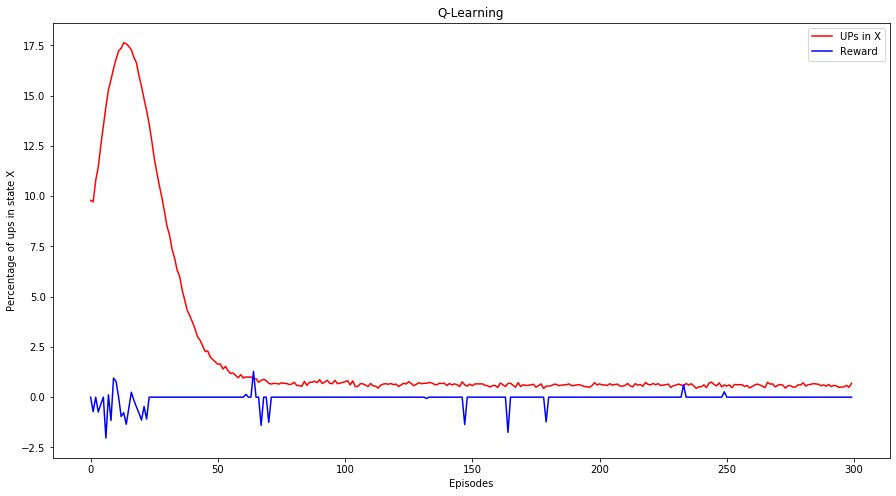

In [1]:
import matplotlib.pyplot as plt
# Full implementation found in additional module.
from q_learn.q_learning import MDP, mdp_q_learning

mdp_environment = MDP()
q_reward, q_table, num_of_ups = mdp_q_learning(mdp_environment)

plt.figure(figsize=(15, 8))
plt.plot(num_of_ups / 10000 * 100, label='UPs in X', color='red')
plt.plot(q_reward, color='blue', label='Reward')
plt.legend()
plt.ylabel('Percentage of ups in state X')
plt.xlabel('Episodes')
plt.title(r'Q-Learning')
plt.show()

#### Double Q Learning

One problem with the Q Learning algorithm is that Q-value estimation and action selection are both performed by the same approximation function, in the above case, the estimations produced by combining the Bellman equation with previous state-action table values. Because the maximum Q-value is used for the update (see above equation), in noisy environments the agent will tend to update the policy based on overestimations which ultimately slow training. 

The solution to this problem, proposed by Hasselt, is to introduce a second approximation function which is randomly updated in deference to the other (Hasselt, 2010). When selecting an action, the approximation function used is separate from that evaluating the action, thus achieving the decoupling required to remove overestimations. The so-called Double Q Learning algorithm is especially effective in noisy environments. The image below summarizes the updated algorithm. Note that either approximation function is updated by random choice and that when updating, the other function is used for value approximation.
##### Algorithm

- Algorithm Double Q-learning
    - Initialize $Q^A, Q^B, s$
    - **repeat**
        - Choose $a$, based on $Q^A(s, \cdot)$, observe $r, s'$
        - Choose (e.g. random) either *UPDATE(A)* or *UPDATE(B)*
        - **if** UPDATE(A) **then**
            - Define $a^* = \arg\max_a Q^A(s',a)$
            - $Q^A(s,a) \gets Q^A + \alpha(s,a)(r + \gamma Q^B(s',a^*) - Q^A(s,a))$
        - **else if** UPDATE(B) **then**
            - Define $b^* = \arg\max_a Q^B(s',a)$
            - $Q^B(s,a) \gets Q^B + \alpha(s,a)(r + \gamma Q^A(s',a^*) - Q^B(s,a))$
        - **end if**
        - $s \gets s'$
    - **until** end


The cell below shows the results of a tabular implementation of this algorithm in the same stochastic environment. Note that training results are improved versus the original Q-Learning algorithm, shown in the number of times the agent selects the unrewarding 'UP' action. This is because the agent is able to avoid the adverse effects of noise-induced overestimation by distributing experiences across the two decoupled approximation functions. In the following graph you can see the two algorithms compared.

#test : 1900


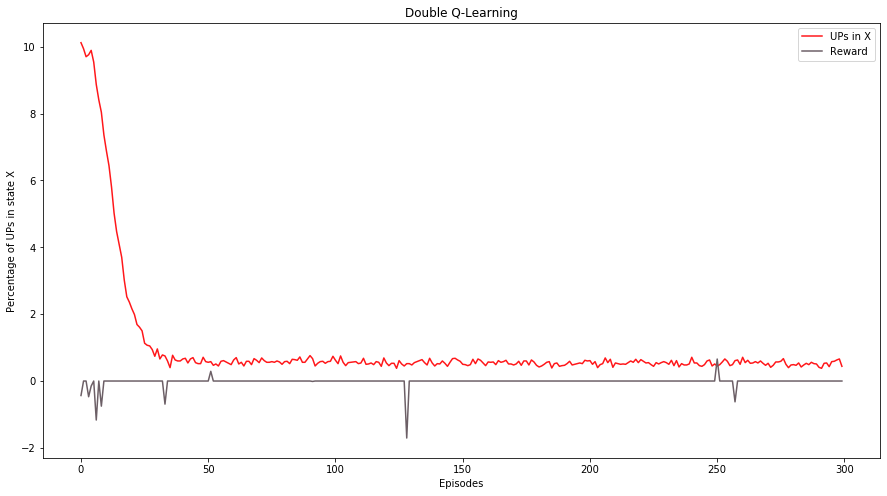

In [4]:
from q_learn.double_q_learning import mdp_double_q_learning

mdp_environment = MDP()
dq_reward, _, _, dq_num_of_ups = mdp_double_q_learning(mdp_environment)

plt.figure(figsize=(15, 8))
plt.plot(dq_num_of_ups / 10000 * 100, label='UPs in X', color='#FF171A')
plt.plot(dq_reward, color='#6C5F66', label='Reward')
plt.legend()
plt.ylabel('Percentage of UPs in state X')
plt.xlabel('Episodes')
plt.title(r'Double Q-Learning')
plt.show()

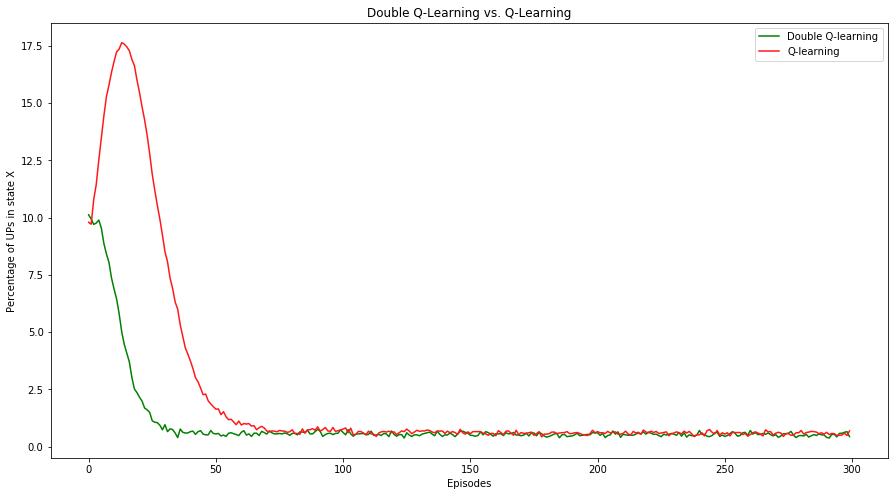

In [5]:
# Visualizing the choices of both agents for comparison.
plt.figure(figsize=(15,8))
plt.plot(dq_num_of_ups/10000*100, label='Double Q-learning', color='g')
plt.plot(num_of_ups/10000*100, label='Q-learning', color='#FF171A')
plt.legend()
plt.ylabel('Percentage of UPs in state X')
plt.xlabel('Episodes')
plt.title(r'Double Q-Learning vs. Q-Learning')
plt.show()

As is clearly visible in the above graph, the Q-learning agent explores the unrewarding UP action much more than the Double Q-learning agent during initial stages episodes, due to the overestimation of the stochastic rewards for this action which are neatly avoided by the Double Q-learning agent. Thus, although both agents can ultimately reach an optimal policy, the Double Q-learning agent is more efficient.

### Deep Q Learning

In more complex environments, such as OpenAI gym environments, a tabular representation is infeasible because of the sheer amount of state-action pairs. Thus, a more efficient means of updating and representing the agent policy is by introducing a neural network to replace the tabular approximation function. By iteratively training a network on batches of experiences, Mnih et al showed that neural reinforcement learning is an effective update to the original Q-Learning algorithm (Mnih et al, 2015).

The cells below demonstrate the Deep Q Learning algorithm proposed by Mnih et al, which is based on the original Q-Learning algorithm. As such, this method reproduces the kinds of overestimation errors suggested by Hasselt and his colleagues. 

In the following cells we will walk through and explain the relevant sections of the DQN implementation, which will be relevant for the DDQN implementation as well.

In [ ]:
# To organize the information for training, we must create an agent which will 
# iteratively train itself within the openAI gym environment. This is achieved via
# an 'Agent' class.

class Agent:
  """
  Reinforcement learning agent to implement DQN and DDQN algorithms.
  """
  def get_action(self, state, eps):
    pass


  def train(self,exp_buffer):
    pass


  def learn(self):
    pass


  def visualize_training(self):
    pass

In [ ]:
# The agent has four functions:
  # The get action function will select the next action the agent should take, 
  # given the current state of the environment. In this function we implement
  # the so-called 'epsilon greedy policy', which allows the agent to explore the
  # environment at early 

In [ ]:
dqn_experience = ExperienceBuffer(max_experiences, min_experiences)
dqn_train_network = Qnetwork(num_states, hidden_units, num_actions)
dqn_agent = Agent(train_net=dqn_train_network, gamma=gamma, batch_size=batch_size, 
                  num_actions=num_actions, algorithm='dqn', experience=dqn_experience)

dqn_agent.learn()
dqn_agent.visualize_training()

In [ ]:
make_video(env, dqn_agent)
env.close()
show_video()

In [ ]:
dqn_train_network.save_weights('DQN_cart_pole.h5')
weights_file = drive.CreateFile({'title' : 'DQN_cart_pole.h5'})
weights_file.SetContentFile('DQN_cart_pole.h5')
weights_file.Upload()
drive.CreateFile({'id': weights_file.get('id')})

### Deep Reinforcement Learning with Double Deep Q Learning


The DDQN algorithm is the Double Q version of the DQN algorithm. In their 2015 paper, Hasselt et al. investigated the performance of the aforementioned DQN algorithm and showed that it also produces systematic non-uniform overestimations which lead to suboptimal agent policies. Since the introduction of the Q-learning algorithm in 1989, it was known that this algorithm sometimes led to suboptimal policies and overestimated values, but the exact causes or solutions for these inadequacies were unknown (Watkins, 1989). As early as 1993, it was hypothesized that inflexible function approximations and noise led to such overestimations, and in their paper, Hasselt et al experimentally demonstrate the truth of these hypotheses in relation to the network update procedures of the DQN algorithm (Thrun & Schwartz, 1993).

Because the DQN algorithm ultimately trains only one Q-value approximation network, the algorithm reproduces same unnecessary conjunction of action selection and evaluation from Q learning, which, if decoupled, could lead to a uniform estimation distribution which would mitigate the effects of overestimation. Effectively, if all Q-values are equally overestimated ie in a normal distribution, then overestimation becomes a non-issue for the training protocol, and this uniformity can be achieved by the introduction of an additional Q-value into the original Q/DQN-learning algorithm. In the DDQN algorithm, estimation uniformity is achieved by requisitioning the target network's parameters and, rather than simply copying them from the online network, using them in conjunction with the online network to randomly update either one of two sets of parameters, θ or θ', representing the parameters of the online or target network, respectively. As Hasselt et al state, "... two value functions are learned by assigning experience randomly to update one of the two value functions, such that there are two sets of weights ..." (Hasselt et al., 2015).

It is worth noting that Hasselt's proposal for implementing the DDQN algorithm still involves only two networks rather than four, which could be implied given that the DQN algorithm involves two networks and implements only a single Q-value. In Hasselt's estimation, leveraging the DQN target network for representing the second Q-value function is "the minimal possible change to DQN towards Double Q-Learning. The goal is to get most of the benefit of Double Q-Learning, while keeping the rest of the DQN algorithm intact for a fair comparison" (Hasselt et al, 2015, p4). Thus, in our implementation we stick with the two network structure suggested by Hasselt et al, conceding that other interpretations of the DDQN algorithm are possible.

By randomly selecting updates for the Q and Q' approximation functions, the Double Q-learning algorithm is able to remove the non-uniform estimation biases seen in the single-Q-value learning algorithms. Hasselt et al demonstrate these results in the following graph, which shows that when estimating Q values with a single approximation function, as the number of actions increases, the estimations (red) systematically increase. However, when an additional approximation function (blue) is introduced, there appears no overestimation bias as a function of increasing number of actions, suggesting that the suboptimal policy training is mitigated by the additional value. In our project we intended to replicate these results by implementing the Double Deep Q learning algorithm, which uses two neural networks for approximating the separate Q-values.


![alt text](http://drive.google.com/uc?export=view&id=1SNdOFx9PpIeRewXuWarM6CqiQXbkRcXj)

In [ ]:
ddqn_experience = ExperienceBuffer(max_experiences, min_experiences)
ddqn_train_network = Qnetwork(num_states, hidden_units, num_actions)
ddqn_target_network = Qnetwork(num_states, hidden_units, num_actions)
ddqn_agent = Agent(train_net=dqn_train_network, target_net=ddqn_target_network, 
                   gamma=gamma, batch_size=batch_size, num_actions=num_actions, 
                   algorithm='ddqn', experience=ddqn_experience)

ddqn_agent.learn()
ddqn_agent.visualize_training()

In [ ]:
make_video(env, ddqn_agent)
env.close()
show_video()

In [ ]:
ddqn_train_network.save_weights('DDQN_train_cart_pole.h5')
ddqn_target_network.save_weights('DDQN_target_cart_pole.h5')
weights_file = drive.CreateFile({'title' : 'DQN_cart_pole.h5'})
weights_file.SetContentFile('DQN_cart_pole.h5')
weights_file.Upload()
drive.CreateFile({'id': weights_file.get('id')})

### Results

In [ ]:
fig = plt.figure(figsize=(16,5))
loss_ax = fig.add_subplot(1,2,1)
plt.plot(dqn_agent.train_steps, dqn_agent.train_losses, label='DQN')
plt.plot(ddqn_agent.train_steps,ddqn_agent.train_losses, label='DDQN')
loss_ax.title.set_text('Loss plot')
plt.legend()


loss_ax.set_xlabel('Episodes')
loss_ax.set_ylabel('Loss')

rewards_ax = fig.add_subplot(1,2,2)
plt.plot(dqn_agent.train_steps, dqn_agent.train_rewards, label='DQN')
plt.plot(ddqn_agent.train_steps, ddqn_agent.train_rewards, label='DDQN')
rewards_ax.title.set_text('Reward plot')
plt.legend()

rewards_ax.set_xlabel('Episode')
rewards_ax.set_ylabel('Rewards')
plt.show()


# Visualization of results
# Comparison between DQN and DDQN
# Make a graph like in the 2015 paper.
# Add video file from producing agent.
# Showing how the overestimation is resolved.
# Make more modular - execution, visualization.
# Plot DQN and DDQN in same graph.
# Run test for 100 iterations and compare.
# Save models and submit such that they can rerun it easily.

#################TODO######################

### References

* Hasselt, Hado. (2010). Double Q-learning.. 2613-2621. 

* Hasselt, Hado & Guez, Arthur & Silver, David. (2015). Deep Reinforcement Learning with Double Q-learning. 

* Mnih, Volodymyr & Kavukcuoglu, Koray & Silver, David & Rusu, Andrei & Veness, Joel & Bellemare, Marc & Graves, Alex & Riedmiller, Martin & Fidjeland, Andreas & Ostrovski, Georg & Petersen, Stig & Beattie, Charles & Sadik, Amir & Antonoglou, Ioannis & King, Helen & Kumaran, Dharshan & Wierstra, Daan & Legg, Shane & Hassabis, Demis. (2015). Human-level control through deep reinforcement learning. Nature. 518. 529-33. 10.1038/nature14236. 

* Watkins, Christopher. (1989). Learning From Delayed Rewards. PhD Thesis. University of Cambridge.

* Thrun, Sebastian & Schwartz, Anton. (1993). Issues in Using Function Approximation for Reinforcement Learning. In Proceedings of the Fourth Connectionist Models Summer School. Erlbaum.
